<a href="https://www.kaggle.com/code/joshuacurtiswebb/simuledge?scriptVersionId=141679145" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
from spx_strategies import *

#########################
# VERSION
#########################
notebook_name = 'simuledge'
notebook_v=0

#########################
# DATA CONFIGURATION
#########################
load_cboe = False
load_tradier = True

#########################
# STUDY CONFIGURATION
#########################
op_sel = DeltaOptionSelector
ent_pol_study = OptionSelectorStaticEntryPolicy
ex_pol_study = HoldToExpStaticExitPolicy
study_param_ranges = {
    'sp':(0.005,0.45),
    'lp':(0.002,''),
    'sc':(0.005,0.45),
    'lc':(0.002,''),
}

misc_configs_ent_pol = {    
    'dte':1,
    'pt':'16:00:00'}

misc_configs_ex_pol ={
}

misc_configs_strat ={
    'comm':1.5,
    'ipv': 0.2
}
misc_configs_strat['ds'] = 'tradier' if load_tradier else 'cboe'
# IPV will be overwritten when data is loaded
initial_portfolio_value = 1





In [2]:
import logging
import sys
import pandas as pd
import numpy as np
from datetime import datetime, date, timedelta, time
import matplotlib.pyplot as plt
from time import perf_counter
import optuna
import os
from shutil import copy
from textwrap import wrap
pd.set_option("max_columns", 200)

#copy db
cwd = os.getcwd()
output_spx_spread_backtester_path = '/kaggle/input/simuledge/'
dir_list = os.listdir(output_spx_spread_backtester_path)
files = [f for f in dir_list if os.path.isfile(output_spx_spread_backtester_path+f) and ".db" in f] #Filtering only the db files.
for f in files:
    if not os.path.exists(cwd+'/'+f):
        print(f"Copying db file to output : {f}")
        copy(output_spx_spread_backtester_path+f,cwd+'/'+f)


Copying db file to output : optimal-short-ic-study_2023-2023_1DTE_2023-08-26-22.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-07-31-20.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-08-13-22.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-08-14-22.db
Copying db file to output : optimal-short-ic-study_2023-2023_1DTE_2023-08-23-22.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-08-01-15.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-08-17-22.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-08-12-22.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-08-08-23.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-08-18-22.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-08-22-22.db
Copying db file to output : optim

In [3]:
def ipv_transform(df, scaling_factor):
    if 'price' not in df.columns:
        raise Exception("Need 'price' in dataframe")
        
    return df.loc[1,'price']*scaling_factor*100


In [4]:
if load_cboe:

    files = [
    #     f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2020_0dte_all.csv", 
    #     f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2021_0dte_all.csv", 
    #    f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2022_0dte_all.csv"
        #f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2021_1545_1600.csv",
       # f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2020_1545_1600.csv"
       # f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2022_1545_1600.csv"
     #  f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2019_1545_1600.csv"
      #  f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2018_1545_1600.csv"
       # f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2017_1545_1600.csv"
      # f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2016_1545_1600.csv"
       f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2019_1dte_all.csv",
        f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2020_1dte_all.csv",
        f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2021_1dte_all.csv",
        f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2022_1dte_all.csv"
    ]
    li = []
    for f in files:   
        df = pd.read_csv(f, index_col=None, header=0, dtype={'type':'category','quote_time':'category'})
        li.append(df)

    df = pd.concat(li, axis=0, ignore_index=True)
    df['expiration']=pd.to_datetime(df['expiration'],infer_datetime_format=True)
    df['quote_date']=pd.to_datetime(df['quote_date'],infer_datetime_format=True)
    df['delta'] = df['delta'].abs()

    if 'dte' not in df:
        raise Exception("dte must be present")

    df_ty = pd.read_csv(f"/kaggle/input/treasury-yield-13w-2012-2022/13_week_treasury_yield.csv", index_col=None, header=0)
    df_ty['Date'] = pd.to_datetime(df_ty['Date'])
    
    df_irx = df_ty

In [5]:
if load_tradier:
    for dirname, _, filenames in os.walk('/kaggle/input/spx-option-chain-1dte-all-times'):
        for f in filenames:
            if 'spx' in f:
                df = pd.read_csv(os.path.join(dirname, f), index_col=None, header=0)
                df.rename(columns={'underlying':'price'},inplace=True)
                df.drop(columns=['Unnamed: 0'], inplace=True)
                df['expiration']=pd.to_datetime(df['expiration'],infer_datetime_format=True)
                df['quote_date']=pd.to_datetime(df['quote_date'],infer_datetime_format=True)
                df['delta'] = df['delta'].abs()
            elif 'irx' in f:
                df_irx = pd.read_csv(os.path.join(dirname, f), index_col=None, header=0)
                df_irx.rename(columns={'close':'Adj Close','quote_date':'Date'},inplace=True)
                df_irx['Adj Close']*= 100
                df_irx['Date']=pd.to_datetime(df_irx['Date'],infer_datetime_format=True)
                df_irx['quote_time']=pd.to_datetime(df_irx['quote_time'],infer_datetime_format=True)
                df_irx = df_irx.loc[df_irx.groupby('Date')['quote_time'].idxmax()]
                df_irx.drop(columns=['Unnamed: 0', 'quote_time'], inplace=True)


In [6]:
# For whatever data we've loaded, create an initial portfolio value
initial_portfolio_value = ipv_transform(df, misc_configs_strat['ipv'])

# Backtest Optimization

In [7]:
# purchase_time = '16:01:00'
# dos = DeltaOptionSelector(short_puts=0.04, short_calls=0.02)
# # dos = YieldOptionSelector(short_puts=0.0006, short_calls=0.0003, ipv=initial_portfolio_value)
# ent_pol=OptionSelectorStaticEntryPolicy(1, purchase_time, dos)
# #ex_pol = HoldToExpStaticExitPolicy('16:00:00')
# ex_pol = MaxLossDynamicExitPolicy(1.5)
# strat = StaticEntryDynamicExitStrategy(commission, df_irx, initial_portfolio_value, ent_pol, ex_pol, debug=True)
# strat.evaluate(df)


In [8]:
def run_backtest(strat, df):
    return strat.evaluate(df)['Cumulative Return']

In [9]:
def objective(trial, df, purchase_time):
    delta_sp_trial = trial.suggest_float('sp', study_param_ranges['sp'][0], study_param_ranges['sp'][1])
    delta_lp_trial = trial.suggest_float('lp', study_param_ranges['lp'][0], delta_sp_trial)
    delta_sc_trial = trial.suggest_float('sc', study_param_ranges['sc'][0], study_param_ranges['sc'][1])
    delta_lc_trial = trial.suggest_float('lc', study_param_ranges['lc'][0], delta_sc_trial)
   
    dos = op_sel(short_puts=delta_sp_trial, long_puts=delta_lp_trial,short_calls=delta_sc_trial, long_calls=delta_lc_trial)
    ent_pol=ent_pol_study(misc_configs_ent_pol['dte'], misc_configs_ent_pol['pt'], dos)
    
    ex_pol = ex_pol_study()

    strategy = StaticEntryStaticExitStrategy(misc_configs_strat['comm'], df_irx, initial_portfolio_value, ent_pol, ex_pol, debug=False)
    score = run_backtest(strategy, df)
    return score

In [10]:
# The following code builds the fully described study, including entry and exit policy, data, trial search params, etc

new_study_name = op_sel.__name__ + '_' + ent_pol_study.__name__

# concatenate ranges first
for k,v in study_param_ranges.items():
    new_study_name+="_"+k+"_"+str(v[0])+"_"+str(v[1])
    
# concatenate static values second
for k,v in misc_configs_ent_pol.items():
    new_study_name += f"_{k}_{v}"
        
new_study_name += f"_{ex_pol_study.__name__}"
        
for k,v in misc_configs_ex_pol.items():
    new_study_name += f"_{k}_{v}"
        
for k,v in misc_configs_strat.items():
    new_study_name += f"_{k}_{v}"
            
new_study_name += df['quote_date'].min().date().strftime("%y%m%d") +'_' + df['quote_date'].max().date().strftime("%y%m%d")

new_study_name += "_spx_st_" + str(spx_strat_v)

new_study_name += "_" + notebook_name + "_" + str(notebook_v)
    
new_study_name = study_name_reducer(new_study_name)

In [11]:

study_name = new_study_name  # Unique identifier of the study.
storage_name = "sqlite:///{}.db".format(study_name)
study = optuna.create_study(direction = "maximize", study_name=study_name, storage=storage_name, load_if_exists=True)
study.optimize(lambda trial: objective(trial, df, misc_configs_ent_pol['pt']), n_trials = 10)
trial = study.best_trial
print("Best Score: ", trial.value)
print("Best Params: ")
for key, value in trial.params.items():
    print("  {}: {}".format(key, value))

[I 2023-09-01 19:35:57,615] A new study created in RDB with name: DOS_OSSEntryP_sp_0.005_0.45_lp_0.002__sc_0.005_0.45_lc_0.002__dte_1_pt_16:00:00_HTESExitP_comm_1.5_ipv_0.2_ds_tradier230714_230831_spx_st_0_simuledge_0
[I 2023-09-01 19:36:02,758] Trial 0 finished with value: -1.162 and parameters: {'sp': 0.30380758386514295, 'lp': 0.14602851110477344, 'sc': 0.08093405782481645, 'lc': 0.0330074553181265}. Best is trial 0 with value: -1.162.
[I 2023-09-01 19:36:07,744] Trial 1 finished with value: -0.207 and parameters: {'sp': 0.08037410885531852, 'lp': 0.006565146488980395, 'sc': 0.04793352447867732, 'lc': 0.008626802175175094}. Best is trial 1 with value: -0.207.
[I 2023-09-01 19:36:12,693] Trial 2 finished with value: -2.779 and parameters: {'sp': 0.3610711720058221, 'lp': 0.35538707061084246, 'sc': 0.03210178584065574, 'lc': 0.022991986585374366}. Best is trial 1 with value: -0.207.
[I 2023-09-01 19:36:17,681] Trial 3 finished with value: -0.505 and parameters: {'sp': 0.22890734233576

Best Score:  5.598
Best Params: 
  lc: 0.36256068566743765
  lp: 0.1833835964541046
  sc: 0.4207200024462387
  sp: 0.2883598350323813


# Backtest with current best score

*****  BACKTEST RESULTS  ****
Cumulative Return                                 5.598
Max Drawdown                                     -0.645
Mean Net Max Loss                               814.926
Max Net Max Loss                                 1442.5
Mean Return on Max Risk                           0.085
Std Dev of Return on Max Risk                     0.735
Risk Adj Cumulative Return On Scaled Max Risk     7.616
Trading Days                                         34
Wins                                                 19
Losses                                               15
Breakeven                                             0
Win/Loss Ratio                                   55.882
Mean Win                                        336.921
Mean Loss                                      -355.867
Mean Net Trans                                   31.279
Std Dev of Net Trans                              450.1
Max Loss                                        -1026.0
Max Win           

,trade_date,expiration,trade_count,strike_sp_0,strike_sc_0,strike_lc_0,strike_lp_0,delta_sp_target_0,delta_sp_0,collected_sp_0,delta_sc_target_0,delta_sc_0,collected_sc_0,delta_lc_target_0,delta_lc_0,collected_lc_0,delta_lp_target_0,delta_lp_0,collected_lp_0,collected,lost_c,lost_p,price,commission,lost,net,portfolio_value,net_cumsum,transaction_return,cum_return,daily_risk_free_return,gross_max_loss,net_max_loss,return_on_max_risk,scaled_return_on_max_risk
0,2023-07-14,2023-07-17,4.0,4490.0,4510.0,4515.0,4480.0,0.28836,0.286450,467.5,0.42072,0.419038,780.0,0.362561,0.346514,-600.0,0.183384,0.178156,-262.5,385.0,500.0,0.0,4526.69,6.0,500.0,-121.0,90079.8,-121.0,NaN,-0.001341,0.000207,1000.0,615.0,-0.196748,0.996065
1,2023-07-17,2023-07-18,2.0,4510.0,4535.0,4535.0,4500.0,0.28836,0.269545,467.5,0.42072,0.351153,0.0,0.362561,0.351153,0.0,0.183384,0.165757,-250.0,217.5,0.0,0.0,4558.32,3.0,0.0,214.5,90294.3,93.5,0.002381,0.001037,0.000208,1000.0,782.5,0.274121,1.005482
2,2023-07-18,2023-07-19,4.0,4540.0,4565.0,4570.0,4530.0,0.28836,0.246720,407.5,0.42072,0.394381,617.5,0.362561,0.313604,-457.5,0.183384,0.152134,-225.0,342.5,348.0,0.0,4568.48,6.0,348.0,-11.5,90282.8,82.0,-0.000127,0.000909,0.000208,1000.0,657.5,-0.017490,0.999650
3,2023-07-19,2023-07-20,4.0,4550.0,4575.0,4580.0,4540.0,0.28836,0.259541,467.5,0.42072,0.418772,855.0,0.362561,0.357224,-710.0,0.183384,0.166846,-270.0,342.5,0.0,1000.0,4534.01,6.0,1000.0,-663.5,89619.3,-581.5,-0.007349,-0.006447,0.000208,1000.0,657.5,-1.009125,0.979817
4,2023-07-20,2023-07-21,4.0,4520.0,4545.0,4550.0,4510.0,0.28836,0.288242,477.5,0.42072,0.369584,775.0,0.362561,0.307275,-590.0,0.183384,0.177861,-262.5,400.0,0.0,0.0,4537.79,6.0,0.0,394.0,90013.3,-187.5,0.004396,-0.002079,0.000208,1000.0,600.0,0.656667,1.013133
5,2023-07-21,2023-07-24,4.0,4520.0,4545.0,4550.0,4510.0,0.28836,0.244659,417.5,0.42072,0.414824,717.5,0.362561,0.335813,-532.5,0.183384,0.153185,-237.5,365.0,500.0,0.0,4552.82,6.0,500.0,-141.0,89872.3,-328.5,-0.001566,-0.003642,0.000208,1000.0,635.0,-0.222047,0.995559
6,2023-07-24,2023-07-25,4.0,4540.0,4560.0,4565.0,4530.0,0.28836,0.279923,405.0,0.42072,0.406195,785.0,0.362561,0.333312,-582.5,0.183384,0.169521,-225.0,382.5,500.0,0.0,4571.38,6.0,500.0,-123.5,89748.8,-452.0,-0.001374,-0.005011,0.000208,1000.0,617.5,-0.200000,0.996000
7,2023-07-25,2023-07-26,4.0,4545.0,4585.0,4590.0,4525.0,0.28836,0.285413,862.5,0.42072,0.380224,1100.0,0.362561,0.337122,-935.0,0.183384,0.159938,-405.0,622.5,0.0,0.0,4566.59,6.0,0.0,616.5,90365.3,164.5,0.006869,0.001824,0.000209,2000.0,1377.5,0.447550,1.008951
8,2023-07-26,2023-07-27,4.0,4550.0,4575.0,4580.0,4540.0,0.28836,0.258299,417.5,0.42072,0.403442,892.5,0.362561,0.339728,-685.0,0.183384,0.167403,-257.5,367.5,0.0,1000.0,4533.77,6.0,1000.0,-638.5,89726.8,-474.0,-0.007066,-0.005255,0.000209,1000.0,632.5,-1.009486,0.979810
9,2023-07-27,2023-07-28,4.0,4510.0,4545.0,4550.0,4495.0,0.28836,0.263828,627.5,0.42072,0.405842,1255.0,0.362561,0.355416,-990.0,0.183384,0.173930,-400.0,492.5,500.0,0.0,4578.72,6.0,500.0,-13.5,89713.3,-487.5,-0.000150,-0.005405,0.000209,1500.0,1007.5,-0.013400,0.999732


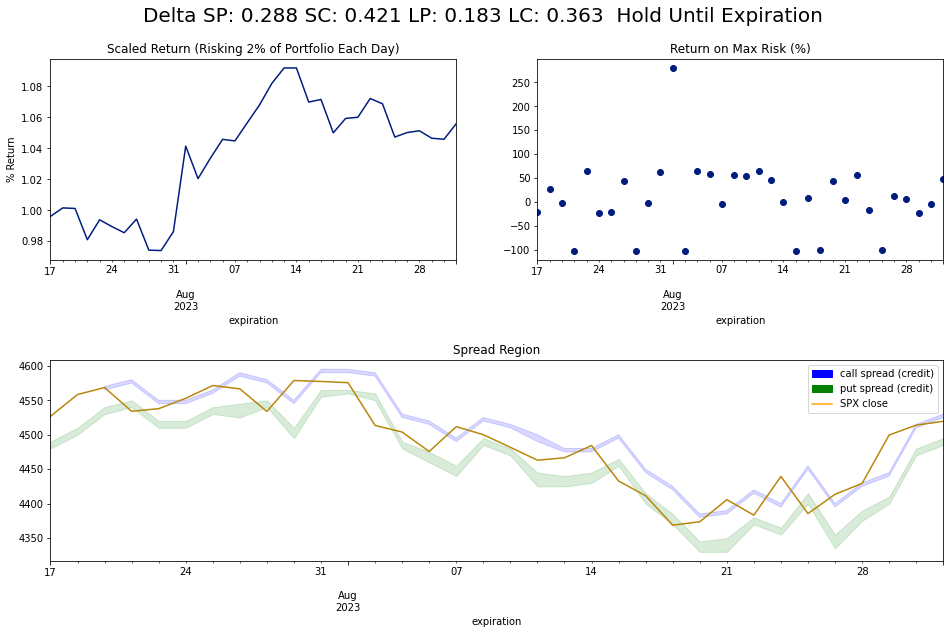

In [12]:
dos = DeltaOptionSelector(short_puts=trial.params['sp'],short_calls=trial.params['sc'], long_puts=trial.params['lp'],long_calls=trial.params['lc'])
ent_pol=OptionSelectorStaticEntryPolicy(1, misc_configs_ent_pol['pt'], dos)
ex_pol = HoldToExpStaticExitPolicy()
strat = StaticEntryStaticExitStrategy(misc_configs_strat['comm'], df_irx, initial_portfolio_value, ent_pol, ex_pol, debug=True)
strat.evaluate(df)

strat.df_trades

# Strikes for tomorrow with current best

In [13]:
next_exp = df['expiration'].max()
quote_date_next_exp = df[(df['expiration']==df['expiration'].max())&(df['quote_date']!=df['expiration'].max())]['quote_date'].iloc[0]
df_trades = pd.DataFrame([{'trade_date':quote_date_next_exp,'expiration':next_exp}])
df_filt = df[
    (df['expiration']==df['expiration'].max())&
    (df['quote_date']!=df['expiration'].max())&
    (df['quote_time']=='16:00:00')
]

In [14]:
dos = DeltaOptionSelector(short_puts=trial.params['sp'],short_calls=trial.params['sc'], long_puts=trial.params['lp'],long_calls=trial.params['lc'])
ent_pol=OptionSelectorStaticEntryPolicy(1, '16:01:00', dos)
dos.populateTrades(df_filt,df_trades,ent_pol.get_contract_strike)

,trade_date,expiration,delta_sp_target_0,strike_sp_0,delta_sp_0,collected_sp_0,delta_sc_target_0,strike_sc_0,delta_sc_0,collected_sc_0,delta_lc_target_0,strike_lc_0,delta_lc_0,collected_lc_0,delta_lp_target_0,strike_lp_0,delta_lp_0,collected_lp_0,trade_count,collected
0,2023-08-31,2023-09-01,0.28836,4495.0,0.275512,730.0,0.42072,4525.0,0.416916,690.0,0.362561,4530.0,0.340983,-540.0,0.183384,4480.0,0.164731,-365.0,4,515.0


# Strikes following the 4/2 Strategy

In [15]:
dos = DeltaOptionSelector(short_puts=0.04,short_calls=0.02)
ent_pol=OptionSelectorStaticEntryPolicy(1, '16:01:00', dos)
dos.populateTrades(df_filt,df_trades,ent_pol.get_contract_strike)

,trade_date,expiration,delta_sp_target_0,strike_sp_0,delta_sp_0,collected_sp_0,delta_sc_target_0,strike_sc_0,delta_sc_0,collected_sc_0,delta_lc_target_0,strike_lc_0,delta_lc_0,collected_lc_0,delta_lp_target_0,strike_lp_0,delta_lp_0,collected_lp_0,trade_count,collected
0,2023-08-31,2023-09-01,0.04,4445.0,0.037433,62.5,0.02,4585.0,0.016634,15.0,0.362561,4530.0,0.340983,-540.0,0.183384,4480.0,0.164731,-365.0,4,-827.5
